# Is ADAM better than RMSprop and Momentum, but what about SGD?

An interesting paper [submitted on May 23 2017](https://arxiv.org/abs/1705.08292) discussed over the marginal value of adaptive gradient methods in Deep Learning. They also found out that SGD (Stochastic Gradient Descent) performed better than the adaptive optimizers such as ADAM, RMSprop etc.

They state:

*Adaptive optimization methods, which perform local optimization with a metric constructed from the history of iterates, are becoming increasingly popular for training deep neural networks. Examples include AdaGrad, RMSProp, and Adam. We show that for simple overparameterized problems, adaptive methods often find drastically different solutions than gradient descent (GD) or stochastic gradient descent (SGD). We construct an illustrative binary classification problem where the data is linearly separable, GD and SGD achieve zero test error, and AdaGrad, Adam, and RMSProp attain test errors arbitrarily close to half. We additionally study the empirical generalization capability of adaptive methods on several state-of-the-art deep learning models. **We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks***

## Here I take a look at one Kaggle's Dogs vs Cats Redux competition dataset example to test if that's true$^{[1]}$

**Based model used**: ResNet50

**Layer**: output features => Dense(256) => Dropout(0.5) => Dense(32) => Dropout(0.5) => Dense(1) => output(sigmoid)

**Data used**: dogs-vs-cats redux images from fast.ai (consists of 23K training data & 2K val data)

**Method**: Train layers for 300 epochs with ReduceLROnPlateau() callback function and evaluate performance on validation accuracy and loss (binary cross-entropy loss) for a few algorithms.

$[1]$: Again, it still is and continues to be debatable, we will however comtinue to test on this data set and try to arrive and some generic conclusion as to what works best given certain conditions.

## TL;DR - its false!

$[1]$Whatever you may be reading across the internet after this paper was published. **ADAM** still rules!

(P.S: I used latest keras 2.0.8, TF at backend was 1.3.x, Python 3.6+)

In [1]:
! git clone https://github.com/fastai/courses.git

Cloning into 'courses'...
remote: Counting objects: 765, done.
remote: Total 765 (delta 0), reused 0 (delta 0), pack-reused 765
Receiving objects: 100% (765/765), 22.40 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [3]:
!wget http://files.fast.ai/data/dogscats.zip

--2017-09-30 01:47:04--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  19.4MB/s    in 65s     

2017-09-30 01:48:09 (12.6 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [ ]:
! unzip output/dogscats.zip

In [ ]:
%cd output/dogscats/test1/
%mv *.jpg /home/deeplearn/deepfun/keras/output/dogscats/test/unknown/

In [67]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau
import h5py
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
path = 'output/dogscats/'
batch_size = 32

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(path+'train', image_size, shuffle=False, 
                                              batch_size=batch_size)
    valid_generator = gen.flow_from_directory(path+'valid', image_size, shuffle=False, 
                                              batch_size=batch_size)
    test_generator = gen.flow_from_directory(path+'test', image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.samples/batch_size)
    valid = model.predict_generator(valid_generator, valid_generator.samples/batch_size)
    test = model.predict_generator(test_generator, test_generator.samples)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("valid", data=valid)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        h.create_dataset("val_label", data=valid_generator.classes)

In [3]:
%time write_gap(ResNet50, (224, 224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
CPU times: user 45min 54s, sys: 6min 20s, total: 52min 14s
Wall time: 36min 17s


In [4]:
%time write_gap(Xception, (299, 299), xception.preprocess_input)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
CPU times: user 1h 12min 53s, sys: 12min 32s, total: 1h 25min 25s
Wall time: 1h 7min 14s


In [ ]:
%time write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

### Let's combine the output features of ResNet50, Xception and InceptionV3 

In [69]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [70]:
X_train.shape

(23000, 2048)

In [71]:
y_train.shape

(23000,)

In [78]:
X_train.shape[1:]

(2048,)

### Model 1: ADAM
#### We define the input tensor, Dropout, Density and output.  

In [ ]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, batch_size=batch_size*2, epochs=5, validation_data=(X_valid, y_valid))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 0.0131 - acc: 0.9954 - val_loss: 0.0224 - val_acc: 0.9945
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 0.0139 - acc: 0.9957 - val_loss: 0.0177 - val_acc: 0.9955
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.0134 - acc: 0.9959 - val_loss: 0.0223 - val_acc: 0.9960
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.0149 - acc: 0.9957 - val_loss: 0.0234 - val_acc: 0.9930
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.0155 - acc: 0.9951 - val_loss: 0.0223 - val_acc: 0.9960


#### With batchsize*4 = 128 

In [19]:
model.fit(X_train, y_train, batch_size=batch_size*4, epochs=5, validation_data=(X_valid, y_valid))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 0.0099 - acc: 0.9965 - val_loss: 0.0222 - val_acc: 0.9960
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 0.0102 - acc: 0.9965 - val_loss: 0.0223 - val_acc: 0.9955
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0245 - val_acc: 0.9945
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.0101 - acc: 0.9964 - val_loss: 0.0200 - val_acc: 0.9965
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0204 - val_acc: 0.9960


### Model 2: NADAM
#### We define the input tensor, Dropout, Density and output. 

In [16]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

from keras.optimizers import Nadam
model.compile(optimizer=Nadam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Let's test and see if we can do a bit of optimization

**

In [15]:
model.fit(X_train, y_train, batch_size=batch_size*2, epochs=5, validation_data=(X_valid, y_valid))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 1s - loss: 0.0364 - acc: 0.9870 - val_loss: 0.0191 - val_acc: 0.9940
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 0.0174 - acc: 0.9943 - val_loss: 0.0169 - val_acc: 0.9945
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.0149 - acc: 0.9956 - val_loss: 0.0167 - val_acc: 0.9945
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.0154 - acc: 0.9950 - val_loss: 0.0189 - val_acc: 0.9940
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0190 - val_acc: 0.9960


In [17]:
model.fit(X_train, y_train, batch_size=batch_size*4, epochs=5, validation_data=(X_valid, y_valid))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 0.0457 - acc: 0.9841 - val_loss: 0.0173 - val_acc: 0.9940
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0166 - val_acc: 0.9940
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.0153 - acc: 0.9953 - val_loss: 0.0148 - val_acc: 0.9955
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.0136 - acc: 0.9953 - val_loss: 0.0152 - val_acc: 0.9960
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0136 - val_acc: 0.9955


###  ADAM
#### Model Let's make the layer a bit denser...

- Add a relu function
- Add more denser layers
- add and test with learning rate

In [ ]:
# Add more layers
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

# Compile model

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Optimize learning rate

model.optimizer.lr = 1e-5

# run the model

model.fit(X_train, y_train, batch_size=batch_size*4, epochs=5, validation_data=(X_valid, y_valid))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0381 - val_acc: 0.9920
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0229 - val_acc: 0.9940
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.0082 - acc: 0.9975 - val_loss: 0.0228 - val_acc: 0.9950
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.0085 - acc: 0.9976 - val_loss: 0.0242 - val_acc: 0.9965
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.0075 - acc: 0.9974 - val_loss: 0.0228 - val_acc: 0.9955


In [22]:
# Optimize learning rate

model.optimizer.lr = 1e-6

# run the model

model.fit(X_train, y_train, batch_size=batch_size*4, epochs=5, validation_data=(X_valid, y_valid))

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 0.0058 - acc: 0.9980 - val_loss: 0.0295 - val_acc: 0.9920
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 0.0086 - acc: 0.9976 - val_loss: 0.0222 - val_acc: 0.9945
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.0056 - acc: 0.9980 - val_loss: 0.0226 - val_acc: 0.9950
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.0081 - acc: 0.9973 - val_loss: 0.0230 - val_acc: 0.9950
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.0066 - acc: 0.9978 - val_loss: 0.0286 - val_acc: 0.9960


# Let's start with the optimization of our glorious algorithms and see what comes out of it

## Optimizer #1 RMSprop 

In [83]:
# We reduce the learning rate using ReduceLROnPlateau function when val loss performance basically plateus
# or better said, it doesn't improve anymore
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.2,
                                        patience = 5,
                                        min_lr = 1e-5)

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import RMSprop

from keras.optimizers import RMSprop

# Assign

model_RMSprop = Model(input_tensor, x)

# Compile

model_RMSprop.compile(optimizer=RMSprop(),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])

#Run the model 

History_RMSprop = model_RMSprop.fit(X_train, y_train,
                                   batch_size=batch_size*16,
                                   epochs=300,
                                   validation_data=(X_valid, y_valid),
                                   callbacks = [reduce_learning_rate])

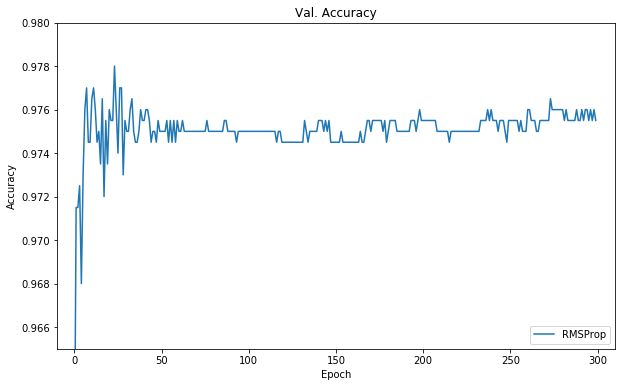

In [86]:
# Visualizing accuracy, 

plt.figure(figsize=(10, 6))  
plt.axis((-10,310,0.965,0.980))

plt.plot(History_RMSprop.history['val_acc'])
plt.title('Val. Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['RMSProp'], loc='lower right')  

plt.show()


#### Visualizing RMSprop

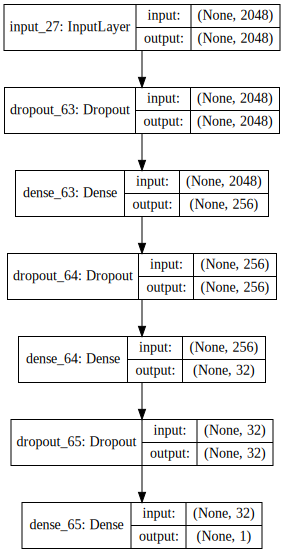

In [87]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
SVG(model_to_dot(model_RMSprop, show_shapes=True).create(prog='dot', format='svg'))

## Optimizer 2 : ADAM

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import ADAM

from keras.optimizers import Adam

# Assign

model_Adam = Model(input_tensor, x)

# Compile

model_Adam.compile(optimizer=Adam(),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])
# Run

History_Adam = model_Adam.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

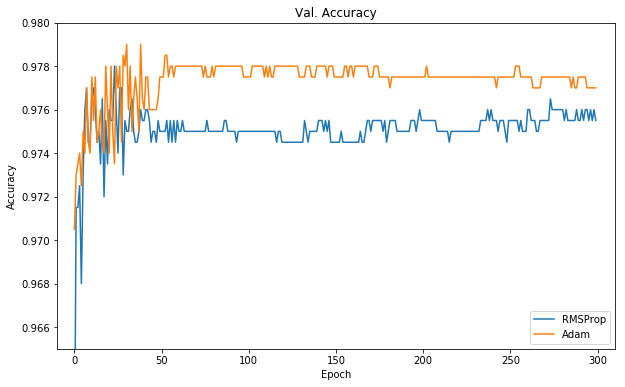

In [89]:
# Visualizing Accuracy

plt.figure(figsize=(10, 6))  
plt.axis((-10,310,0.965,0.980))

plt.plot(History_RMSprop.history['val_acc'])
plt.plot(History_Adam.history['val_acc'])
plt.title('Val. Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['RMSProp', 'Adam'], loc='lower right')  

plt.show()

## Optimizer 3 : SGD

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import SGD

from keras.optimizers import SGD

# Assign

model_SGD = Model(input_tensor, x)

# Compile

model_SGD.compile(optimizer=SGD(),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])
# Run

History_SGD = model_SGD.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

## Optimizer 4 : SGD + Nesterov

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import SGD & Nesterov

from keras.optimizers import SGD

# Assign

model_SGDNES = Model(input_tensor, x)

# Compile

model_SGDNES.compile(optimizer=SGD(nesterov=True),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])

# Run, this time we just run it silently.

History_SGDNES = model_SGDNES.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                                verbose=1,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

## Optimizer 5 : SGD + Momentum (0.9)

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import 

from keras.optimizers import SGD

# Assign

model_SGDMOM = Model(input_tensor, x)

# Compile

model_SGDMOM.compile(optimizer=SGD(momentum=0.9),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])
# Run

History_SGDMOM = model_SGDMOM.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              verbose=1,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

## Optimizer 6 : SGD + Momentum + Nesterov

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import 

from keras.optimizers import SGD

# Assign

model_SGDMOMNES = Model(input_tensor, x)

# Compile

model_SGDMOMNES.compile(optimizer=SGD(momentum=0.9, nesterov=True),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])
# Run

History_SGDMOMNES = model_SGDMOMNES.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              verbose=1,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

## Optimizer 7 : NADAM

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import 

from keras.optimizers import Nadam

# Assign

model_NADAM = Model(input_tensor, x)

# Compile

model_NADAM.compile(optimizer=Nadam(),
                     loss='binary_crossentropy',
                      metrics = ['accuracy'])
# Run

History_NADAM = model_NADAM.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              verbose=1,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

## Optimizer 8: Adamax 

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import 

from keras.optimizers import Adamax

model_Adamax = Model(input_tensor, x)

# Compile

model_Adamax.compile(optimizer=Adamax(),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

# Run

History_Adammax = model_Adamax.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              verbose=1,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_learning_rate])

### Note to myself for Adamax with params playing 


With learning rate 1e-5, explicit in Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

``` 
Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 1.2404 - acc: 0.5074 - val_loss: 0.6780 - val_acc: 0.5970
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 1.0983 - acc: 0.5260 - val_loss: 0.6143 - val_acc: 0.6840
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 0.9851 - acc: 0.5495 - val_loss: 0.5776 - val_acc: 0.7480
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 0.9115 - acc: 0.5681 - val_loss: 0.5520 - val_acc: 0.7840
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 0.8503 - acc: 0.5891 - val_loss: 0.5333 - val_acc: 0.8120
```
**With lr = 1e-6**

Not much of a difference...

```
Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 1.2727 - acc: 0.4913 - val_loss: 0.7638 - val_acc: 0.4630
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 1.2527 - acc: 0.4925 - val_loss: 0.7520 - val_acc: 0.4735
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 1.2141 - acc: 0.5003 - val_loss: 0.7414 - val_acc: 0.4895
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 1.2089 - acc: 0.5024 - val_loss: 0.7318 - val_acc: 0.5015
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 1.2021 - acc: 0.5029 - val_loss: 0.7226 - val_acc: 0.5135
```

**Batch size to 1024 (batch_size = batch_size*32**

```
Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 1.1726 - acc: 0.5055 - val_loss: 0.6665 - val_acc: 0.6050
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 1.1590 - acc: 0.5125 - val_loss: 0.6604 - val_acc: 0.6170
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 1.1578 - acc: 0.5084 - val_loss: 0.6549 - val_acc: 0.6310
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 1.1554 - acc: 0.5089 - val_loss: 0.6498 - val_acc: 0.6390
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 1.1377 - acc: 0.5112 - val_loss: 0.6449 - val_acc: 0.6450
```

**Adamax(), keep lr min to 1e-5 etc**

```
Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 0s - loss: 1.1726 - acc: 0.5055 - val_loss: 0.6665 - val_acc: 0.6050
Epoch 2/5
23000/23000 [==============================] - 0s - loss: 1.1590 - acc: 0.5125 - val_loss: 0.6604 - val_acc: 0.6170
Epoch 3/5
23000/23000 [==============================] - 0s - loss: 1.1578 - acc: 0.5084 - val_loss: 0.6549 - val_acc: 0.6310
Epoch 4/5
23000/23000 [==============================] - 0s - loss: 1.1554 - acc: 0.5089 - val_loss: 0.6498 - val_acc: 0.6390
Epoch 5/5
23000/23000 [==============================] - 0s - loss: 1.1377 - acc: 0.5112 - val_loss: 0.6449 - val_acc: 0.6450
```

## Optimizer 9 :  Adagrad

In [ ]:
#Layers

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Import 

from keras.optimizers import Adagrad

model_Adagrad = Model(input_tensor, x)

# Compile

model_Adagrad.compile(optimizer=Adagrad(),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

# Run

History_Adagrad = model_Adagrad.fit(X_train, y_train, 
                              batch_size=batch_size*16,
                              epochs=300,
                              verbose=1,
                              validation_data=(X_valid,y_valid),
                              callbacks=[reduce_lr])

## Visualizing Accuracy and Loss 

### Valid Set Accuracy

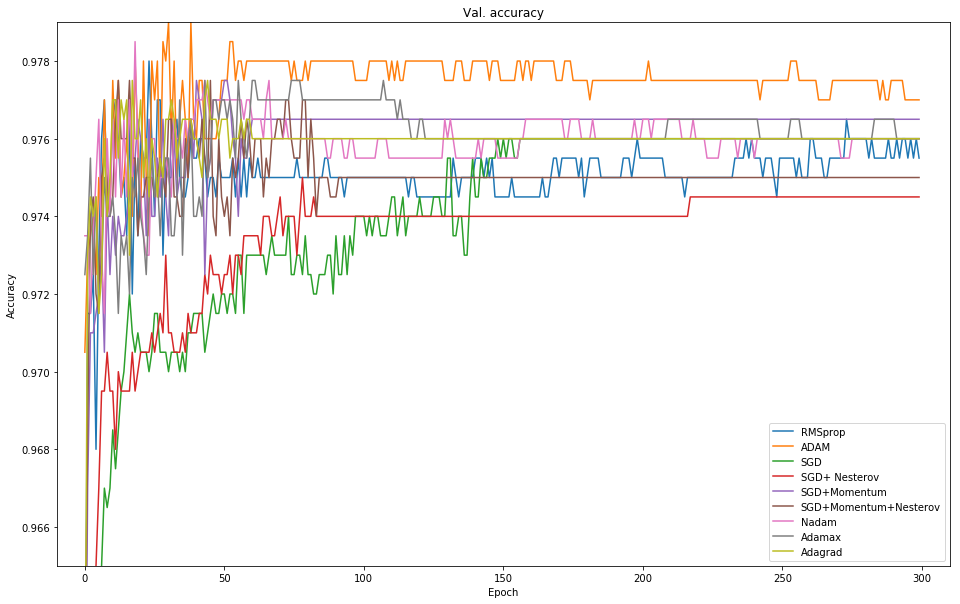

In [111]:
plt.figure(figsize=(16, 10))  
plt.axis((-10,310,0.965,0.979))

plt.plot(History_RMSprop.history['val_acc'])
plt.plot(History_Adam.history['val_acc'])
plt.plot(History_SGD.history['val_acc'])
plt.plot(History_SGDNES.history['val_acc'])
plt.plot(History_SGDMOM.history['val_acc'])
plt.plot(History_SGDMOMNES.history['val_acc'])
plt.plot(History_NADAM.history['val_acc'])
plt.plot(History_Adammax.history['val_acc'])
plt.plot(History_Adagrad.history['val_acc'])
plt.title('Val. accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['RMSprop', 'ADAM', 'SGD', 'SGD+ Nesterov', 'SGD+Momentum', 'SGD+Momentum+Nesterov',
            'Nadam', 'Adamax', 'Adagrad'], loc='lower right')

### ### Training Set Accuracy : Adam wins hands down!

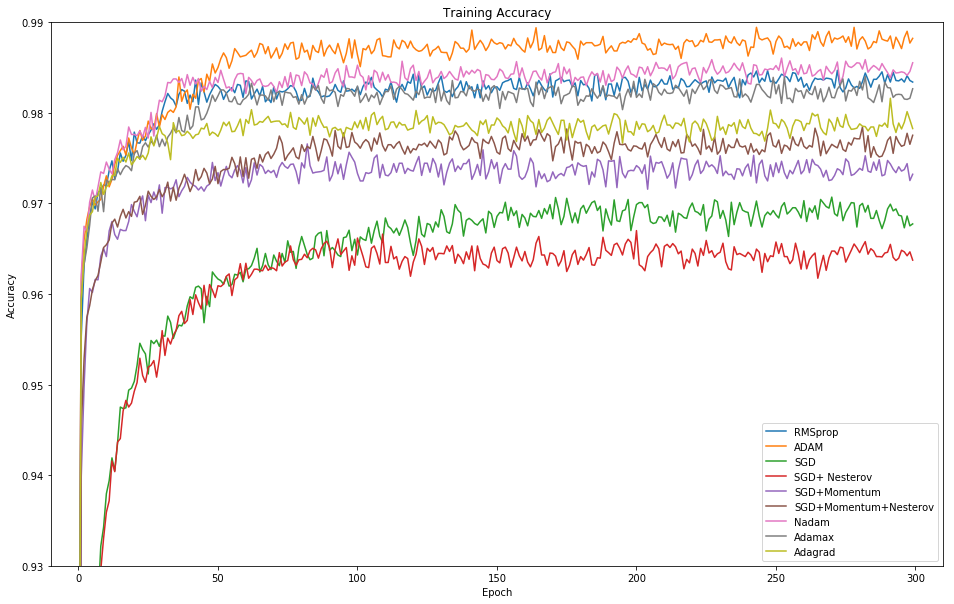

In [115]:
plt.figure(figsize=(16, 10))  
plt.axis((-10,310,0.93,0.99))

plt.plot(History_RMSprop.history['acc'])
plt.plot(History_Adam.history['acc'])
plt.plot(History_SGD.history['acc'])
plt.plot(History_SGDNES.history['acc'])
plt.plot(History_SGDMOM.history['acc'])
plt.plot(History_SGDMOMNES.history['acc'])
plt.plot(History_NADAM.history['acc'])
plt.plot(History_Adammax.history['acc'])
plt.plot(History_Adagrad.history['acc'])
plt.title('Training Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['RMSprop', 'ADAM', 'SGD', 'SGD+ Nesterov', 'SGD+Momentum', 'SGD+Momentum+Nesterov',
            'Nadam', 'Adamax', 'Adagrad'], loc='lower right')
plt.show()

### Valid Loss 

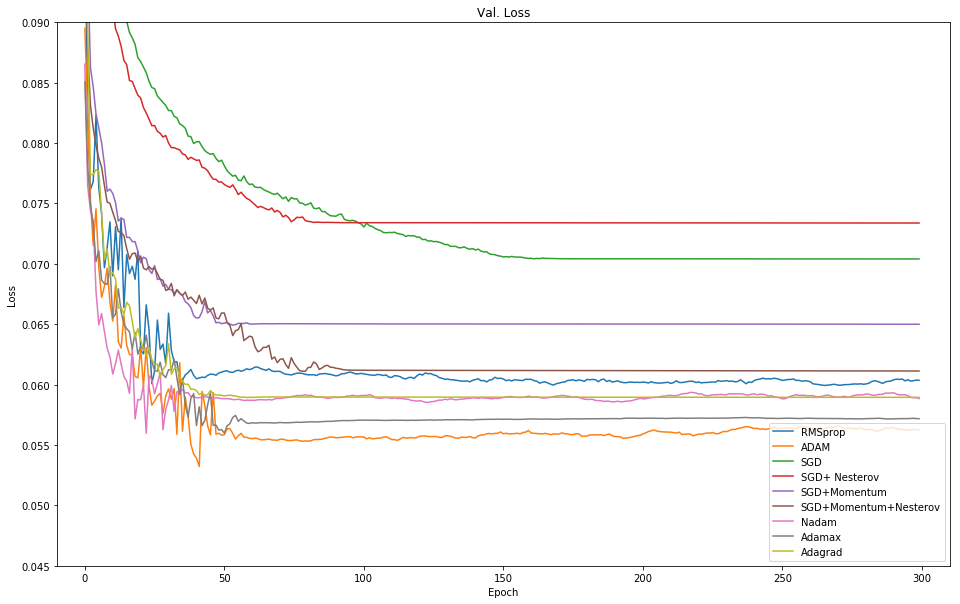

In [114]:
plt.figure(figsize=(16, 10))  
plt.axis((-10,310,0.045,0.09))

plt.plot(History_RMSprop.history['val_loss'])
plt.plot(History_Adam.history['val_loss'])
plt.plot(History_SGD.history['val_loss'])
plt.plot(History_SGDNES.history['val_loss'])
plt.plot(History_SGDMOM.history['val_loss'])
plt.plot(History_SGDMOMNES.history['val_loss'])
plt.plot(History_NADAM.history['val_loss'])
plt.plot(History_Adammax.history['val_loss'])
plt.plot(History_Adagrad.history['val_loss'])
plt.title('Val. Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  

plt.legend(['RMSprop', 'ADAM', 'SGD', 'SGD+ Nesterov', 'SGD+Momentum', 'SGD+Momentum+Nesterov',
            'Nadam', 'Adamax', 'Adagrad'], loc='lower right')

plt.show()

### Training Loss

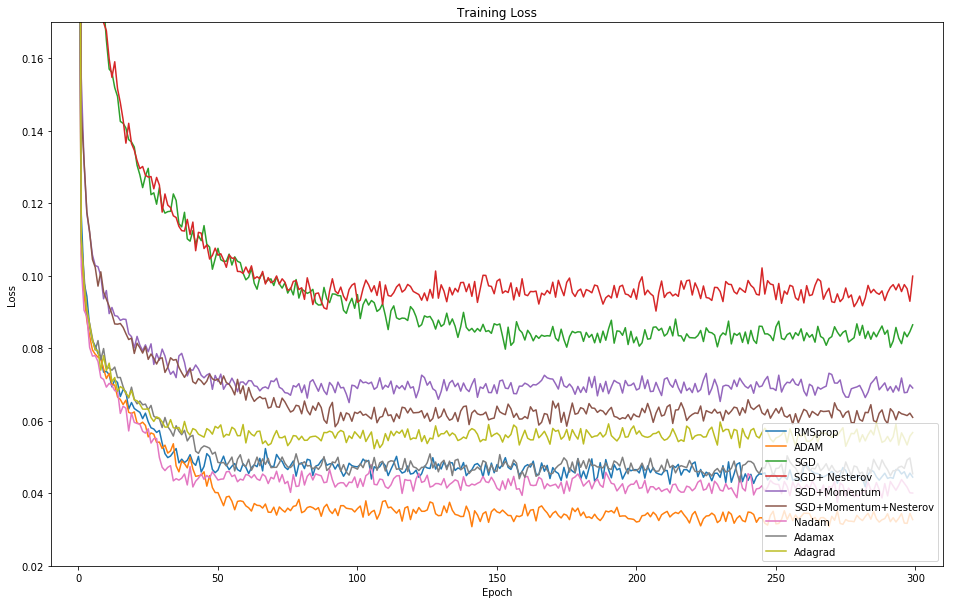

In [117]:
plt.figure(figsize=(16, 10))  
plt.axis((-10,310,0.02,0.17))

plt.plot(History_RMSprop.history['loss'])
plt.plot(History_Adam.history['loss'])
plt.plot(History_SGD.history['loss'])
plt.plot(History_SGDNES.history['loss'])
plt.plot(History_SGDMOM.history['loss'])
plt.plot(History_SGDMOMNES.history['loss'])
plt.plot(History_NADAM.history['loss'])
plt.plot(History_Adammax.history['loss'])
plt.plot(History_Adagrad.history['loss'])
plt.title('Training Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  

plt.legend(['RMSprop', 'ADAM', 'SGD', 'SGD+ Nesterov', 'SGD+Momentum', 'SGD+Momentum+Nesterov',
            'Nadam', 'Adamax', 'Adagrad'], loc='lower right')
plt.show()

## My observations:

- Adam,Nadam have the lowest training loss but you see that SGD & RMSprop come a close second!
- SGD+ Nest performs rather poorly above though!
- Adam still wins hands down in Val training as well

**Concluding (for now)**
There's stil la lot to explore but we can see that Adam is kicking ass.

We basically used a simple FFN (Feed forward neural network) with just three hidden layer, next experiment I'll try with 6 hidden layers.

So, stay tuned!